In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

2024-03-03 23:34:24.424602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 23:34:24.424664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 23:34:24.468137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 23:34:24.556470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-03 23:34:25.839088: W tensorflow/compiler/tf2

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,id,artists,name,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,release_date,speechiness,tempo,valence,popularity
0,7pQSmQ0l7QdBeL9X6CEMbH,['Erroll Garner'],I'll Remember April - Original Edited Concert ...,1955,0.92300,0.438,257693,0.602,0,0.658000,8,0.9500,-14.565,1,1955,0.0408,122.289,0.546,24
1,2g8MTBFRUSFKbY5RQiSSEE,['Maison & Dragen'],Chinese New Year - Radio Edit,2014,0.00019,0.477,193968,0.834,0,0.978000,4,0.3960,-6.534,0,2014-05-02,0.0396,130.007,0.516,0
2,2LcJoQ5SDUZrC2qUjWMEdF,"['Yoel Lerner', 'Mazi Cohen']",השפן הקטן,1981,0.90000,0.617,56827,0.272,0,0.000000,7,0.0879,-16.818,1,1981-04-01,0.0577,83.244,0.807,38
3,6RzHyUtRNARYyn2AIuoLnY,['Barbra Streisand'],Run Wild,1980,0.29400,0.377,247467,0.269,0,0.000478,4,0.1440,-16.766,1,1980-09-23,0.0268,82.302,0.196,40
4,6Kd0I5es8911FZpYhFS053,['Willie Nelson'],Till I Gain Control Again - Live,1975,0.49400,0.501,351560,0.218,0,0.008110,0,0.2970,-13.045,1,1975,0.0283,77.854,0.239,20


In [3]:
train.drop('id', axis=1, inplace=True)

In [4]:
train.drop('release_date', axis=1, inplace=True)

In [5]:
train.shape

(129172, 17)

In [6]:
train['popularity'] = train['popularity'].astype(np.float32)

In [7]:
train.size

2195924

In [8]:
train_df, val_df, test_df = np.split(train.sample(frac=1), [int(0.70*len(train)), int(0.85*len(train))])
print(len(train_df), 'training examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples')


90420 training examples
19376 validation examples
19376 test examples


/home/andre/Documents/Projects/MLLab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('popularity')
  df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds


In [10]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = keras.layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer


In [11]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))


In [12]:
train.head()

,artists,name,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,popularity
0,['Erroll Garner'],I'll Remember April - Original Edited Concert ...,1955,0.92300,0.438,257693,0.602,0,0.658000,8,0.9500,-14.565,1,0.0408,122.289,0.546,24.0
1,['Maison & Dragen'],Chinese New Year - Radio Edit,2014,0.00019,0.477,193968,0.834,0,0.978000,4,0.3960,-6.534,0,0.0396,130.007,0.516,0.0
2,"['Yoel Lerner', 'Mazi Cohen']",השפן הקטן,1981,0.90000,0.617,56827,0.272,0,0.000000,7,0.0879,-16.818,1,0.0577,83.244,0.807,38.0
3,['Barbra Streisand'],Run Wild,1980,0.29400,0.377,247467,0.269,0,0.000478,4,0.1440,-16.766,1,0.0268,82.302,0.196,40.0
4,['Willie Nelson'],Till I Gain Control Again - Live,1975,0.49400,0.501,351560,0.218,0,0.008110,0,0.2970,-13.045,1,0.0283,77.854,0.239,20.0


<Axes: xlabel='popularity'>

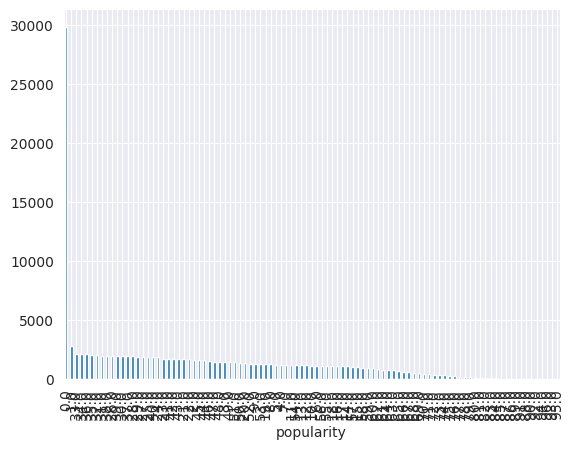

In [13]:
train.popularity.value_counts().plot(kind='bar')

In [14]:
batch_size = 256
train_ds = df_to_dataset(train_df, batch_size=batch_size)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)


2024-03-03 23:34:53.477063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 23:34:53.655883: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
categorical_feats = list(train.select_dtypes(exclude=(np.number)).columns)
numerical_feats = list(train.select_dtypes(include=(np.number)).columns)

print(categorical_feats)
print(numerical_feats)

['artists', 'name']
['year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'popularity']


In [16]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


In [17]:


for header in categorical_feats:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


### Baseline

In [25]:

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(all_features)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.RootMeanSquaredError()])


In [70]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 963.0976 - root_mean_squared_error: 30.9743 - val_loss: 376.9118 - val_root_mean_squared_error: 19.4157
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 334.6841 - root_mean_squared_error: 18.2897 - val_loss: 278.1494 - val_root_mean_squared_error: 16.6757
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 270.2330 - root_mean_squared_error: 16.4383 - val_loss: 254.8071 - val_root_mean_squared_error: 15.9588
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 253.4281 - root_mean_squared_error: 15.9188 - val_loss: 242.0527 - val_root_mean_squared_error: 15.5537
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 239.9436 - root_mean_squared_error: 15.4896 - val_loss: 233.1928 - val_root_mean_squared_error: 15.2663
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 230.3022 - root_mean_squared_error: 15.1755 - val_loss: 225.3604 - val_root_mean_squared_error: 15.0077
Epoch 7/10
354/3

In [71]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 207.0470 - root_mean_squared_error: 14.3889


[207.54800415039062, 14.403416633605957]

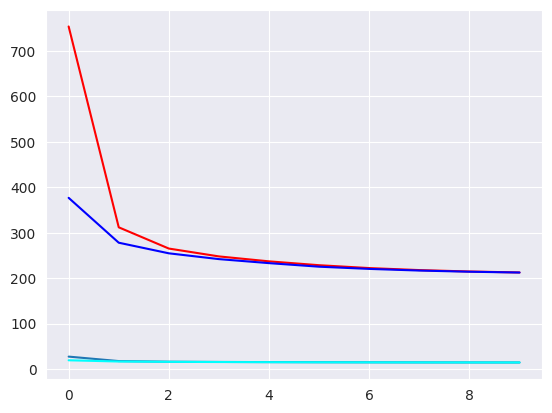

In [73]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Loss Training', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.plot(history.history['root_mean_squared_error'], label='Training Accuracy')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Accuracy', color='cyan')

### Test 1

In [72]:

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(all_features)
x = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.RootMeanSquaredError()])


In [74]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)


Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 697.6720 - root_mean_squared_error: 26.0666 - val_loss: 242.4326 - val_root_mean_squared_error: 15.5647
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 235.9925 - root_mean_squared_error: 15.3599 - val_loss: 206.9554 - val_root_mean_squared_error: 14.3823
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 202.1640 - root_mean_squared_error: 14.2183 - val_loss: 195.9544 - val_root_mean_squared_error: 13.9959
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 192.8044 - root_mean_squared_error: 13.8853 - val_loss: 189.7552 - val_root_mean_squared_error: 13.7730
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 186.2375 - root_mean_squared_error: 13.6460 - val_loss: 186.3936 - val_root_mean_squared_error: 13.6509
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 181.1999 - root_mean_squared_error: 13.4603 - val_loss: 184.2937 - val_root_mean_squared_error: 13.5739
Epoch 7/20
354/3

In [75]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 169.1066 - root_mean_squared_error: 13.0038


[170.38653564453125, 13.048639297485352]

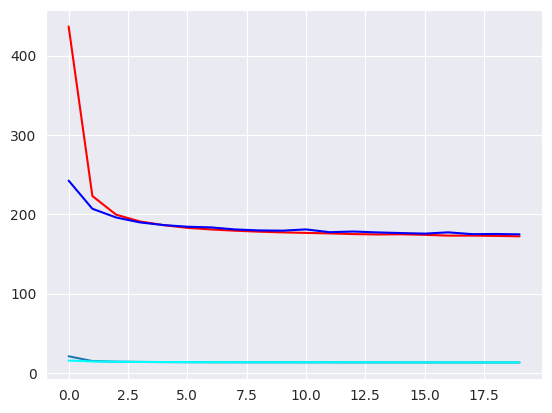

In [78]:
plt.plot(history.history['loss'], label='Loss Training', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.plot(history.history['root_mean_squared_error'], label='Training Accuracy')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Accuracy', color='cyan')

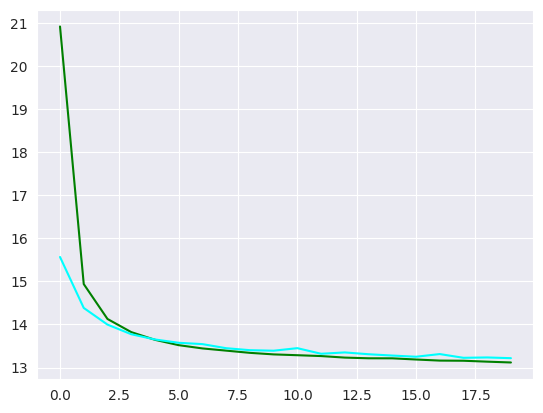

In [80]:
plt.plot(history.history['root_mean_squared_error'], label='Training Accuracy', color='green')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Accuracy', color='cyan')

### Test 2

In [81]:

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="swish", kernel_initializer='he_normal')(all_features)
x = tf.keras.layers.Dense(64, activation="swish", kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.RootMeanSquaredError()])


In [82]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)


Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 500.8316 - root_mean_squared_error: 21.9710 - val_loss: 214.7596 - val_root_mean_squared_error: 14.6507
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 203.9750 - root_mean_squared_error: 14.2812 - val_loss: 193.2063 - val_root_mean_squared_error: 13.8972
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 189.0242 - root_mean_squared_error: 13.7482 - val_loss: 188.2681 - val_root_mean_squared_error: 13.7177
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 185.2233 - root_mean_squared_error: 13.6096 - val_loss: 185.2981 - val_root_mean_squared_error: 13.6106
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 179.3706 - root_mean_squared_error: 13.3925 - val_loss: 182.1000 - val_root_mean_squared_error: 13.4939
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 179.0257 - root_mean_squared_error: 13.3796 - val_loss: 179.1497 - val_root_mean_squared_error: 13.3851
Epoch 7/20
354/3

In [83]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165.3239 - root_mean_squared_error: 12.8575


[166.58900451660156, 12.90184211730957]

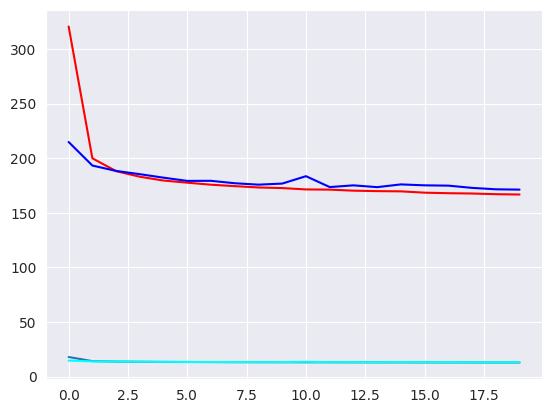

In [84]:
plt.plot(history.history['loss'], label='Loss Training', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.plot(history.history['root_mean_squared_error'], label='Training Accuracy')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Accuracy', color='cyan')

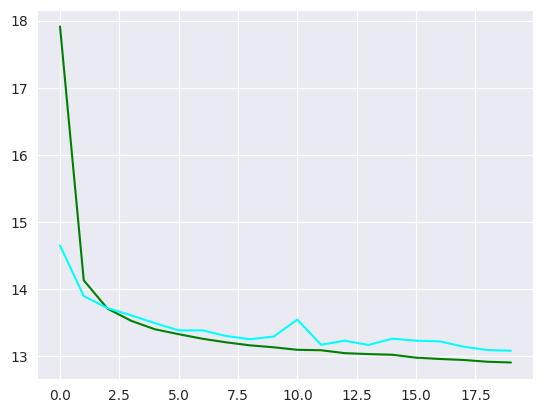

In [85]:
plt.plot(history.history['root_mean_squared_error'], label='Training Accuracy', color='green')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Accuracy', color='cyan')

### Ensemble Models

In [26]:

all_features = tf.keras.layers.concatenate(encoded_features)
x1 = tf.keras.layers.Dense(128, activation="swish", kernel_initializer='he_normal')(all_features)
x1 = tf.keras.layers.Dense(64, activation="swish", kernel_initializer='he_normal')(x1)
x1 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x1)


x2 = tf.keras.layers.Dense(128, activation="swish", kernel_initializer='he_normal')(all_features)
x2 = tf.keras.layers.Dense(64, activation="swish", kernel_initializer='he_normal')(x2)
x2 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x2)


x3 = tf.keras.layers.Dense(128, activation="swish", kernel_initializer='he_normal')(all_features)
x3 = tf.keras.layers.Dense(64, activation="swish", kernel_initializer='he_normal')(x3)
x3 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x3)

concatenated = tf.keras.layers.concatenate([x1, x2, x3])

output = tf.keras.layers.Dense(1)(concatenated)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.RootMeanSquaredError()])

In [27]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)


Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 449.3632 - root_mean_squared_error: 20.7948 - val_loss: 198.9124 - val_root_mean_squared_error: 14.1039
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 195.4173 - root_mean_squared_error: 13.9789 - val_loss: 185.4501 - val_root_mean_squared_error: 13.6192
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 185.0847 - root_mean_squared_error: 13.6043 - val_loss: 183.3478 - val_root_mean_squared_error: 13.5411
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 181.0010 - root_mean_squared_error: 13.4531 - val_loss: 177.9129 - val_root_mean_squared_error: 13.3406
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 177.5762 - root_mean_squared_error: 13.3256 - val_loss: 178.5920 - val_root_mean_squared_error: 13.3649
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 175.7988 - root_mean_squared_error: 13.2586 - val_loss: 175.7400 - val_root_mean_squared_error: 13.2571
Epoch 7/20
354/3

In [28]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 174.1506 - root_mean_squared_error: 13.1944


[169.3726806640625, 13.017106056213379]

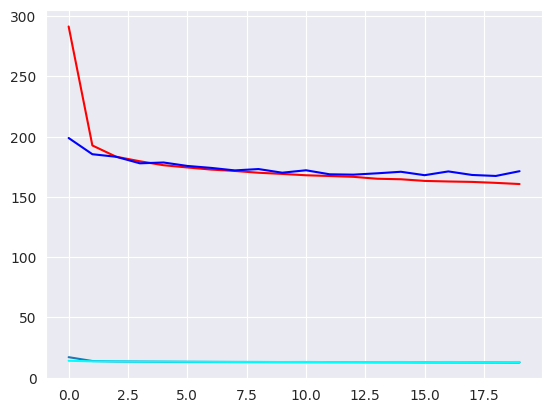

In [29]:
plt.plot(history.history['loss'], label='Loss Training', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.plot(history.history['root_mean_squared_error'], label='Training Accuracy')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Accuracy', color='cyan')

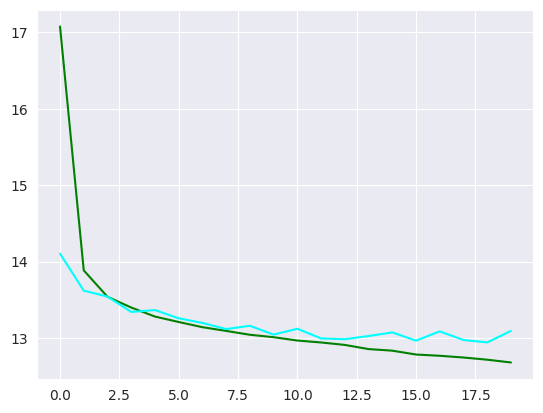

In [30]:
plt.plot(history.history['root_mean_squared_error'], label='Training Accuracy', color='green')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation Accuracy', color='cyan')

### Ensemble - Fined Tuned

In [35]:

all_features = tf.keras.layers.concatenate(encoded_features)
x1 = tf.keras.layers.Dense(128, activation="swish", kernel_initializer='he_normal')(all_features)
x1 = tf.keras.layers.Dense(64, activation="swish", kernel_initializer='he_normal')(x1)
x1 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x1)

x2 = tf.keras.layers.Dense(128, activation="swish", kernel_initializer='he_normal')(all_features)
x2 = tf.keras.layers.Dense(64, activation="swish", kernel_initializer='he_normal')(x2)
x2 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x2)

x3 = tf.keras.layers.Dense(128, activation="swish", kernel_initializer='he_normal')(all_features)
x3 = tf.keras.layers.Dense(64, activation="swish", kernel_initializer='he_normal')(x3)
x3 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x3)

x4 = tf.keras.layers.Dense(128, activation="swish", kernel_initializer='he_normal')(all_features)
x4 = tf.keras.layers.Dense(64, activation="swish", kernel_initializer='he_normal')(x4)
x4 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x4)


concatenated = tf.keras.layers.concatenate([x1, x2, x3, x4])

meta_ensemble = tf.keras.layers.Dense(128, activation="swish")(concatenated)

output = tf.keras.layers.Dense(1)(meta_ensemble)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.RootMeanSquaredError()])
history = model.fit(train_ds, epochs=20, validation_data=val_ds)
model.evaluate(test_ds)


Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 397.7661 - root_mean_squared_error: 19.5225 - val_loss: 188.5433 - val_root_mean_squared_error: 13.7332
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 186.4479 - root_mean_squared_error: 13.6545 - val_loss: 181.6758 - val_root_mean_squared_error: 13.4801
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 181.4957 - root_mean_squared_error: 13.4712 - val_loss: 175.5727 - val_root_mean_squared_error: 13.2519
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 173.6109 - root_mean_squared_error: 13.1757 - val_loss: 174.3062 - val_root_mean_squared_error: 13.2034
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 170.6103 - root_mean_squared_error: 13.0611 - val_loss: 171.5023 - val_root_mean_squared_error: 13.0979
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 169.3980 - root_mean_squared_error: 13.0151 - val_loss: 171.7948 - val_root_mean_squared_error: 13.1075
Epoch 7/20
354/3

[165.11517333984375, 12.851689338684082]


### Ensemble - Weak Learners

In [39]:

all_features = tf.keras.layers.concatenate(encoded_features)
x1 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(all_features)
x1 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x1)
output1 = tf.keras.layers.Dense(1, activation="swish", kernel_initializer='he_normal')(x1)

x2 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x1)
x2 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x2)
output2 = tf.keras.layers.Dense(1, activation="swish", kernel_initializer='he_normal')(x2)

x3 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x2)
x3 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x3)
output3 = tf.keras.layers.Dense(1, activation="swish", kernel_initializer='he_normal')(x3)

x4 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x3)
x4 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x4)
output4 = tf.keras.layers.Dense(1, activation="swish", kernel_initializer='he_normal')(x4)

x5 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x4)
x5 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x5)
output5 = tf.keras.layers.Dense(1, activation="swish", kernel_initializer='he_normal')(x5)

x6 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x5)
x6 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x6)
output6 = tf.keras.layers.Dense(1, activation="swish", kernel_initializer='he_normal')(x6)

x7 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x6)
x7 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x7)
output7 = tf.keras.layers.Dense(1, activation="swish", kernel_initializer='he_normal')(x7)

x8 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x7)
x8 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x8)
output8 = tf.keras.layers.Dense(1, activation="swish", kernel_initializer='he_normal')(x8)



model = tf.keras.Model(all_inputs, output8)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.RootMeanSquaredError()])
history = model.fit(train_ds, epochs=20, validation_data=val_ds)
model.evaluate(test_ds)


Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 490.2665 - root_mean_squared_error: 21.6851 - val_loss: 202.0354 - val_root_mean_squared_error: 14.2186
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 197.8602 - root_mean_squared_error: 14.0660 - val_loss: 194.9472 - val_root_mean_squared_error: 13.9636
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 186.4985 - root_mean_squared_error: 13.6560 - val_loss: 187.0511 - val_root_mean_squared_error: 13.6784
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 182.8577 - root_mean_squared_error: 13.5224 - val_loss: 180.6460 - val_root_mean_squared_error: 13.4427
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 182.1599 - root_mean_squared_error: 13.4959 - val_loss: 182.3163 - val_root_mean_squared_error: 13.5051
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 182.2828 - root_mean_squared_error: 13.5001 - val_loss: 177.6413 - val_root_mean_squared_error: 13.3306
Epoch 7/20
354/3

[171.9942626953125, 13.117323875427246]